In [ ]:
#install the required library
!pip install gymnasium>=1.0.0
!pip install kaggle-environments
!pip install pygame

# 3. Agent trained by Semi Gradient SARSA Algorithm

#### Import libraries

In [27]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from kaggle_environments import make  # Import ConnectX environment
import pickle

#### Define the layers for neural network

In [28]:
# Neural Network Model for Q-value Approximation
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

#### Define the semi gradient sarsa class

In [29]:
class SemiGradientSARSA:
    def __init__(self, env, alpha=0.01, gamma=0.95, epsilon=0.7, epsilon_decay=0.999, lambda_=0.9):
        self.rows = env.configuration.rows
        self.columns = env.configuration.columns
        self.inarow = env.configuration.inarow

        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay  # Epsilon decay
        self.lambda_ = lambda_  # Eligibility trace decay rate

        self.state_size = self.rows * self.columns  # Flattened board size
        self.action_size = self.columns  # Number of valid moves

        # Neural Network for Q-value estimation
        self.q_network = QNetwork(self.state_size, self.action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.alpha)
        self.loss_fn = nn.MSELoss()

        # Eligibility traces
        self.e_traces = {name: torch.zeros_like(param) for name, param in self.q_network.named_parameters()}

    def get_state_representation(self, board, player):
        """Convert board state to a normalized tensor and adjust for player perspective."""
        board_array = np.array(board).reshape(self.rows, self.columns)
        normalized_board = np.where(board_array == player, 1, np.where(board_array == 0, 0, -1))
        return torch.tensor(normalized_board.flatten(), dtype=torch.float32).unsqueeze(0)

    def select_action(self, obs, player):
        """Epsilon-greedy policy."""
        state = self.get_state_representation(obs["board"], player)
        valid_moves = [c for c in range(self.action_size) if obs["board"][c] == 0]

        if len(valid_moves) == 0:
            return None  # Return None if no valid move is available

        if random.uniform(0, 1) < self.epsilon:
            return random.choice(valid_moves)  # Exploration
        else:
            q_values = self.q_network(state).detach().numpy()[0]
            return max(valid_moves, key=lambda x: q_values[x])  # Best valid action

    def decay_epsilon(self):
        """Reduce exploration over time."""
        self.epsilon = max(self.epsilon * self.epsilon_decay, 0.01)

    def reset(self):
        """Reset eligibility traces at the start of each episode."""
        for name in self.e_traces:
            self.e_traces[name].zero_()

    def update(self, state, action, reward, next_state, next_action, done):
        """Semi-Gradient SARSA(λ) update using function approximation."""
        q_values = self.q_network(state)
        q_next = self.q_network(next_state).detach()

        # Compute TD target (convert to tensor)
        target = reward + (self.gamma * q_next[0][next_action] if not done else 0.0)
        target = torch.tensor([target], dtype=torch.float32)  # Convert to tensor

        td_error = target - q_values[0][action]

        # Compute loss and backpropagate
        self.optimizer.zero_grad()
        loss = self.loss_fn(q_values[0][action].unsqueeze(0), target)  # Match shapes
        loss.backward()

        # Update eligibility traces and perform parameter updates
        for name, param in self.q_network.named_parameters():
            self.e_traces[name] = self.gamma * self.lambda_ * self.e_traces[name] + param.grad
            param.grad = self.e_traces[name]  # Apply eligibility traces
        self.optimizer.step()

    # Save the model (Neural Network weights)
    def save_model(self, file_path):
        torch.save(self.q_network.state_dict(), file_path)
        print(f"Model weights saved to {file_path}")

    # Load the model (Neural Network weights)
    def load_model(self, file_path):
        if os.path.exists(file_path):
            self.q_network.load_state_dict(torch.load(file_path))
            self.q_network.eval()  # Set the model to evaluation mode (important for inference)
            print(f"Model weights loaded from {file_path}")
        else:
            print(f"Model not found at {file_path}. Please train the agent first.")

    # Save learned policy from the Neural Network 
    def save_learned_policy(self, file_path):
        """Save the best action per state based on the neural network Q-values."""
        policy = {}
        for state in self.generate_possible_states():
            state_tensor = self.get_state_representation(state, player=1)
            q_values = self.q_network(state_tensor).detach().numpy()[0]
            best_action = np.argmax(q_values)
            policy[state] = best_action
        with open(file_path, 'wb') as f:
            pickle.dump(policy, f)
        print(f"Learned policy saved to {file_path}")

    # Load learned policy
    def load_learned_policy(self, file_path):
        with open(file_path, 'rb') as f:
            policy = pickle.load(f)
        print(f"Learned policy loaded from {file_path}")
        return policy

    

#### Define the training function

In [30]:
def train_agent(env, agent, episodes, epsilon_decay=True, save_model=False, model_path=None, save_policy=False, policy_path=None):
    trainer = env.train([None, 'random']) 
    total_rewards = []
    rewards = []  # To track rewards over episodes
    wins, losses, draws = 0, 0, 0  # To track win/loss/draw counts

    # Load a pre-trained model to resume training
    if model_path:
        agent.load_model(model_path)  # Load pre-trained model

    for episode in range(episodes):
        obs = trainer.reset()  # Reset environment to start new episode
        player = obs.mark  # Get the player's mark (1 or -1)
        done = False
        episode_rewards = []

        # Initialize the state and action at the beginning of each episode
        state = agent.get_state_representation(obs.board, player)
        action = agent.select_action(obs, player)  # Select initial action

        while not done:
            # Perform the action in the environment and get the next state
            next_obs, reward, done, _ = trainer.step(action)
            
            # Get the next state and next action (only if not done)
            next_state = agent.get_state_representation(next_obs.board, player)
            next_action = agent.select_action(next_obs, player) if not done else None

            # Update the agent using Semi-Gradient SARSA(λ) update rule
            agent.update(state, action, reward, next_state, next_action, done)

            # Transition to the next state and action
            state, action = next_state, next_action
            episode_rewards.append(reward)

        # Track total rewards for the episode
        total_reward = sum(episode_rewards)
        total_rewards.append(total_reward)

        # Apply epsilon decay 
        if epsilon_decay:
            agent.decay_epsilon()

        # Track rewards
        rewards.append(total_reward)

        # Track the game outcomes
        if total_reward == 1: 
            wins += 1
        elif total_reward == -1: 
            losses += 1
        else:
            draws += 1

        # Print progress every 100 episodes
        if (episode + 1) % 100 == 0:
            win_rate = wins / max(1, episode + 1)  # Calculate win rate
            avg_reward = np.mean(rewards[-100:])  # Average reward over the last 100 episodes
            print(f"Episode {episode + 1}: Win Rate: {win_rate:.2f}, Avg Reward: {avg_reward:.2f}")

    # Save the model after training
    if save_model:
        agent.save_model("sarsa_lambda_trained_model.pth")

    # Save the learned policy after training
    if save_policy:
        agent.save_learned_policy("learned_policy.pkl")

    print("\nTraining completed.")
    return total_rewards  # Return the rewards from all episodes for evaluation



#### Define the Evaluation Function

In [31]:
def evaluate_agent(env, agent, episodes, model_path='sarsa_lambda_trained_model.pth', interval=10, epsilon=0.01):
    # Load the model 
    if model_path:
        agent.load_model(model_path)  
        print(f"Model loaded from {model_path}")
    
    # Set epsilon to a low value (close to 0) 
    agent.epsilon = epsilon  # Ensures no exploration during evaluation

    trainer = env.train([None, 'random']) 
    # Metrics Initialization
    wins, losses, draws = 0, 0, 0
    total_rewards = []
    total_td_errors = []
    win_rates = []
    reward_variances = []

    for episode in range(1, episodes + 1):
        obs = trainer.reset()
        player = obs.mark  # Get player ID (1 or -1)
        done = False
        episode_rewards = []
        episode_td_errors = []
        steps = 0

        state = agent.get_state_representation(obs.board, player)
        action = agent.select_action(obs, player)

        while not done:
            next_obs, reward, done, _ = trainer.step(action)
            next_state = agent.get_state_representation(next_obs.board, player)
            next_action = agent.select_action(next_obs, player) if not done else None

            # Compute TD Error
            q_values = agent.q_network(state)  # Q-values for the current state
            q_next = agent.q_network(next_state).detach() if not done else torch.zeros_like(q_values)  # Next state Q-values
            target = reward + agent.gamma * q_next[0][next_action] if not done else reward
            td_error = target - q_values[0][action]  # TD error calculation

            # Store results
            episode_rewards.append(reward)
            episode_td_errors.append(abs(td_error.item()))  # Store the absolute TD error

            # Move to the next state and action
            state, action = next_state, next_action
            steps += 1

        total_rewards.append(sum(episode_rewards))
        total_td_errors.append(np.mean(episode_td_errors))

        # Calculate reward variance over the last `interval` episodes
        if len(total_rewards) >= interval:
            reward_variance = np.var(total_rewards[-interval:])
        else:
            reward_variance = np.var(total_rewards)  # Handle the first few episodes when less than interval

        # Determine match outcome for the current episode
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

        # Store win rate and other metrics at intervals
        if episode % interval == 0:
            win_rate = wins / max(1, (wins + losses + draws))  # Avoid division by zero
            avg_reward = np.mean(total_rewards[-interval:])
            avg_td_error = np.mean(total_td_errors[-interval:])
            
            # Store and print evaluation metrics at each interval
            win_rates.append(win_rate)
            reward_variances.append(reward_variance)
            print(f"After {episode} episodes: "
                  f"Win Rate: {win_rate:.2f}, "
                  f"Avg Reward: {avg_reward:.2f}, "
                  f"TD Error: {avg_td_error:.2f}, "
                  f"Reward Variance: {reward_variance:.2f}")

    # Final summary after all episodes
    print(f"\nFinal Results after {episodes} episodes:")
    print(f"Wins: {wins}, Losses: {losses}, Draws: {draws}, Win Rate: {wins / max(1, episodes):.2f}")

    # Return the evaluation results in a dictionary
    return {
        "win_rates": win_rates,
        "total_rewards": total_rewards,
        "td_errors": total_td_errors,
        "reward_variance": reward_variances
    }


#### Train and evaluate the agent

In [32]:
# Environment Creation
env = make("connectx", {"rows": 4, "columns": 5, "inarow": 3}, steps=[], debug=True)

# Initialize SARSA(λ) Agent with the environment
sarsa_agent = SemiGradientSARSA(env)

# Train the Agent
rewards = train_agent(env, sarsa_agent, episodes=10000)

# Evaluate trained SARSA(λ) agent
results = evaluate_agent(env, sarsa_agent, episodes=500, interval=10)
# Access metrics
win_rates = results["win_rates"]
Avarage_rewards = results["total_rewards"]
td_error = results["td_errors"]




Episode 100: Win Rate: 0.66, Avg Reward: 0.32
Episode 200: Win Rate: 0.66, Avg Reward: 0.32
Episode 300: Win Rate: 0.63, Avg Reward: 0.12
Episode 400: Win Rate: 0.63, Avg Reward: 0.28
Episode 500: Win Rate: 0.64, Avg Reward: 0.34
Episode 600: Win Rate: 0.65, Avg Reward: 0.44
Episode 700: Win Rate: 0.64, Avg Reward: 0.10
Episode 800: Win Rate: 0.65, Avg Reward: 0.50
Episode 900: Win Rate: 0.66, Avg Reward: 0.40
Episode 1000: Win Rate: 0.66, Avg Reward: 0.40
Episode 1100: Win Rate: 0.67, Avg Reward: 0.46
Episode 1200: Win Rate: 0.67, Avg Reward: 0.40
Episode 1300: Win Rate: 0.68, Avg Reward: 0.48
Episode 1400: Win Rate: 0.68, Avg Reward: 0.42
Episode 1500: Win Rate: 0.68, Avg Reward: 0.38
Episode 1600: Win Rate: 0.68, Avg Reward: 0.40
Episode 1700: Win Rate: 0.68, Avg Reward: 0.42
Episode 1800: Win Rate: 0.68, Avg Reward: 0.44
Episode 1900: Win Rate: 0.69, Avg Reward: 0.50
Episode 2000: Win Rate: 0.69, Avg Reward: 0.54
Episode 2100: Win Rate: 0.70, Avg Reward: 0.62
Episode 2200: Win Rate

#### Visualize the result

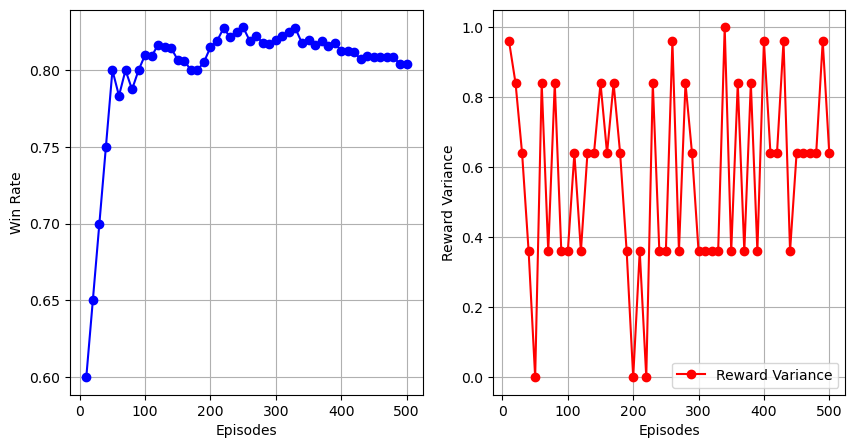

In [34]:
    plt.figure(figsize=(10, 5))

    # Plot win rates
 
    plt.subplot(1, 2, 1)  # Create a subplot for win rate
    plt.plot(range(10, 501, 10), win_rates, marker="o", linestyle="-", color="b", label="win_rates")
    plt.xlabel('Episodes')
    plt.ylabel('Win Rate')
    #plt.title('Win Rate Over Episodes')
    plt.grid(True)

  # Plot reward variance
    plt.subplot(1, 2, 2) 
    plt.plot(range(10, 501, 10), results["reward_variance"], marker="o", linestyle="-", color="r", label="Reward Variance")
    plt.xlabel("Episodes")
    plt.ylabel("Reward Variance")
    #plt.title("Reward Variance Over Time")
    plt.legend()
    plt.grid()

# Test the Agent

#### 1. Play with random

In [ ]:
# Save the model weights after training
sarsa_agent.save_model("sarsa_lambda_trained_model.pth")

# Function wrapper to get actions from SARSA agent
def sarsa_agent_function(obs):
    # Assuming choose_action requires obs and player as arguments
    return sarsa_agent.select_action(obs, obs.mark)  # Pass the player id (obs.mark)
# Set epsilon to a low value (close to 0) for evaluation (no exploration)
sarsa_agent.epsilon = 0.01 
# Train SARSA(λ) as Player 1 against random (Player 2)
trainer = env.train([None, "random"])

num_games = 40  # Set the number of games to play

# Initialize win, loss, and draw counters
wins, losses, draws = 0, 0, 0

for game in range(num_games):
    obs = trainer.reset()  # Reset the environment at the start of each game
    done = False

    while not done:  # Keep playing until the game ends
        action = sarsa_agent_function(obs)  # Get action from the SARSA agent
        obs, reward, done, info = trainer.step(action)  # Perform the action in the environment

    # After the game ends, check the result and print the outcome
    if reward == 1:
        wins += 1
        print(f"Game {game + 1} Over! Player 1 (SARSA) won!")
    elif reward == -1:
        losses += 1
        print(f"Game {game + 1} Over! Player 1 (SARSA) lost!")
    else:
        draws += 1
        print(f"Game {game + 1} Over! It's a draw!")

    # render the game after each game to visually check the board
    env.render(mode='ipython')

# Print summary after all games
print(f"\nSummary after {num_games} games:")
print(f"Wins: {wins}")
print(f"Losses: {losses}")
print(f"Draws: {draws}")


#### 2. Play with negamax

In [ ]:
# Save the model weights after training
sarsa_agent.save_model("sarsa_lambda_trained_model.pth")

# Function wrapper to get actions from SARSA agent
def sarsa_agent_function(obs):
    # Assuming choose_action requires obs and player as arguments
    return sarsa_agent.select_action(obs, obs.mark)  # Pass the player id (obs.mark)
# Set epsilon to a low value (close to 0) for evaluation (no exploration)
sarsa_agent.epsilon = 0.01 
# Train SARSA(λ) as Player 1 against negamax (Player 2)
trainer = env.train([None, "negamax"])

num_games = 40  # Set the number of games to play

# Initialize win, loss, and draw counters
wins, losses, draws = 0, 0, 0

for game in range(num_games):
    obs = trainer.reset()  # Reset the environment at the start of each game
    done = False

    while not done:  # Keep playing until the game ends
        action = sarsa_agent_function(obs)  # Get action from the SARSA agent
        obs, reward, done, info = trainer.step(action)  # Perform the action in the environment

    # After the game ends, check the result and print the outcome
    if reward == 1:
        wins += 1
        print(f"Game {game + 1} Over! Player 1 (SARSA) won!")
    elif reward == -1:
        losses += 1
        print(f"Game {game + 1} Over! Player 1 (SARSA) lost!")
    else:
        draws += 1
        print(f"Game {game + 1} Over! It's a draw!")

    # render the game after each game to visually check the board
    env.render(mode='ipython')

# Print summary after all games
print(f"\nSummary after {num_games} games:")
print(f"Wins: {wins}")
print(f"Losses: {losses}")
print(f"Draws: {draws}")



### Hyper parameter tunning

In [86]:
# Define a function to train and evaluate the agent with specific hyperparameters
def evaluate_sarsa(agent_params):
    sarsa_agent = SemiGradientSARSA(
        env, 
        alpha=agent_params['alpha'], 
        gamma=agent_params['gamma'], 
        epsilon=agent_params['epsilon'], 
        epsilon_decay=agent_params['epsilon_decay'], 
        lambda_=agent_params['lambda_']
    )
    rewards = train_sarsa_lambda(env, sarsa_agent, episodes=1000)
    results = evaluate_agent(env, sarsa_agent, episodes=500, interval=10)
    return results

# Grid search example
alpha_values = [0.01, 0.05, 0.1]
gamma_values = [0.9, 0.95, 0.99]
epsilon_values = [0.5, 0.7, 1.0]
lambda_values = [0.7, 0.8, 0.9]
epsilon_decay_values = [0.999, 0.9995]

# Perform grid search
best_params = None
best_performance = -float('inf')

for alpha in alpha_values:
    for gamma in gamma_values:
        for epsilon in epsilon_values:
            for lambda_ in lambda_values:
                for epsilon_decay in epsilon_decay_values:
                    params = {
                        'alpha': alpha,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'lambda_': lambda_,
                        'epsilon_decay': epsilon_decay
                    }
                    print(f"Evaluating parameters: {params}")
                    results = evaluate_sarsa(params)
                    
                    # Evaluate performance (e.g., based on win rates or reward)
                    performance = np.mean(results['win_rates'])  # Example metric
                    
                    if performance > best_performance:
                        best_performance = performance
                        best_params = params

print(f"Best parameters: {best_params} with performance: {best_performance}")


Evaluating parameters: {'alpha': 0.01, 'gamma': 0.9, 'epsilon': 0.5, 'lambda_': 0.7, 'epsilon_decay': 0.999}
Episode 0: Reward: 1
Episode 100: Reward: 1
Episode 200: Reward: -1
Episode 300: Reward: 1
Episode 400: Reward: 1
Episode 500: Reward: -1
Episode 600: Reward: 1
Episode 700: Reward: 1
Episode 800: Reward: -1
Episode 900: Reward: -1
After 10 episodes: Win Rate: 0.70, Avg Reward: 0.40, Reward Variance: 0.84, Exploration Ratio: 0.23
After 20 episodes: Win Rate: 0.75, Avg Reward: 0.60, Reward Variance: 0.64, Exploration Ratio: 0.20
After 30 episodes: Win Rate: 0.77, Avg Reward: 0.60, Reward Variance: 0.64, Exploration Ratio: 0.17
After 40 episodes: Win Rate: 0.72, Avg Reward: 0.20, Reward Variance: 0.96, Exploration Ratio: 0.16
After 50 episodes: Win Rate: 0.74, Avg Reward: 0.60, Reward Variance: 0.64, Exploration Ratio: 0.17
After 60 episodes: Win Rate: 0.72, Avg Reward: 0.20, Reward Variance: 0.96, Exploration Ratio: 0.17
After 70 episodes: Win Rate: 0.74, Avg Reward: 0.80, Reward